In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize

# from matplotlib import rcParam
import seaborn as sb
import os
import sys

sys.setrecursionlimit(1000000)
from scipy.stats import spearmanr
from scipy.spatial.distance import cdist
import pathlib
import scipy as sp
import scipy.stats as stats
from sklearn.linear_model import LinearRegression
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache

mcc = MouseConnectivityCache()
from scipy.stats import pearsonr
import itertools
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import umap
import hdbscan
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
import scanpy as sc
import anndata as ad
from preprocessing_sequencing import preprocess_sequences as ps
from decimal import Decimal
from bg_atlasapi import BrainGlobeAtlas
import final_processing_functions as fpf
%matplotlib inline

Load barcode datasets, parameters path, and brain regions table

In [5]:
FIAA456a_parameters = ps.load_parameters(
    directory="/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/FIAA45.6a/Sequencing"
)
FIAA456d_parameters = ps.load_parameters(
    directory="/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/FIAA45.6d/Sequencing"
)

sample_vol_and_regions_FIAA456d =pd.read_pickle(pathlib.Path(FIAA456d_parameters['lcm_directory'])/'sample_vol_and_regions.pkl')
sample_vol_and_regions_FIAA456a =pd.read_pickle(pathlib.Path(FIAA456a_parameters['lcm_directory'])/'sample_vol_and_regions.pkl')
filtered_soma_FIAA456a = pd.read_pickle("/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/FIAA45.6a/Sequencing/barcode_matrix_soma_thresholded.pkl"
)
filtered_soma_FIAA456d = pd.read_pickle("/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/FIAA45.6d/Sequencing/barcode_matrix_soma_thresholded.pkl"
)
ROI_3D_FIAA456a = np.load(
    "/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/FIAA45.6a/LCM/ROI_3D_25.npy"
)
ROI_3D_FIAA456d = np.load(
    "/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/FIAA45.6d/LCM/ROI_3D_25.npy"
)

Create a dataframe of fractions of brain regions in each sample

In [8]:
#first let's define the A1 source sites by taking the barcodes that have max with min amount A1
fpf.get_main_region(sample_vol= pathlib.Path(FIAA456a_parameters['lcm_directory'])/'sample_vol_and_regions.pkl', parameters_path = "/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/FIAA45.6a/Sequencing", use_slurm=True, slurm_folder="/camp/home/turnerb/slurm_logs")

'66128061'

In [9]:
fpf.get_main_region(sample_vol= pathlib.Path(FIAA456d_parameters['lcm_directory'])/'sample_vol_and_regions.pkl', parameters_path = "/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/FIAA45.6d/Sequencing", use_slurm=True, slurm_folder="/camp/home/turnerb/slurm_logs")

'66128094'

In [3]:
all_areas_list = sample_vol_and_regions_FIAA456d['Brain Regions'].explode().astype(int).to_list()
all_areas_list.extend(sample_vol_and_regions_FIAA456a['Brain Regions'].explode().astype(int).to_list())
all_areas_list = [i for i in all_areas_list if i != 0]


In [4]:
all_areas_unique_ids = np.unique(all_areas_list)
all_areas_unique_acronymn = []
for i in all_areas_unique_ids:
    id = fpf.get_id(i)
    all_areas_unique_acronymn.append(id)
#since I've made it so different id's can give the same acronym e.g. different layers of the cortex, you need to get rid of duplicate acronymns
all_areas_unique_acronymn = np.unique(all_areas_unique_acronymn)    
all_area_fractions_FIAA456a = pd.DataFrame(index = filtered_soma_FIAA456a.columns, columns=all_areas_unique_acronymn)
all_area_fractions_FIAA456d = pd.DataFrame(index = filtered_soma_FIAA456d.columns, columns=all_areas_unique_acronymn)


        

cannot go five higher for int
cannot go five higher for mcp
cannot go five higher for VL
cannot go four higher for VL
cannot go three higher for VL
cannot go five higher for moV
cannot go five higher for chpl
cannot go four higher for chpl
cannot go five higher for opt
cannot go five higher for VS
cannot go four higher for VS
cannot go three higher for VS
cannot go two higher for VS
cannot go five higher for py
cannot go five higher for sV
cannot go five higher for st
cannot go five higher for MB
cannot go four higher for MB
cannot go five higher for csc
cannot go five higher for MY
cannot go five higher for STR
cannot go five higher for CB
cannot go four higher for CB
cannot go three higher for CB
cannot go five higher for TH
cannot go five higher for CTXsp
cannot go five higher for P
cannot go five higher for cst
cannot go four higher for cst
cannot go five higher for PAL
cannot go five higher for rust
cannot go four higher for rust
cannot go five higher for amc
cannot go five higher

In [38]:
#Because I cut broad areas of the midbrain and thalamus, I want to exclude areas as target
#areas if they are not targets in bulk tracing. I therefore get a list, and manually 
#check if region is a target, and if not, the region is excluded from the table.
bg_atlas = BrainGlobeAtlas("allen_mouse_10um", check_latest=False)
MB_list =[]
thalamus_list =[]
for i in all_areas_unique_acronymn:
    ancestors= bg_atlas.get_structure_ancestors(i)
    if 'MB' in ancestors:
        MB_list.append(i)
    if 'TH'in ancestors:
        thalamus_list.append(i)

In [59]:
MB_list

['APN', 'IC', 'IF', 'IPN', 'NOT', 'NPC', 'OP', 'PPT', 'SCm', 'SCs']

In [60]:
thalamus_list

['AD',
 'AMd',
 'AMv',
 'AV',
 'CL',
 'Eth',
 'IAD',
 'IGL',
 'IntG',
 'LD',
 'LGd',
 'LGv',
 'LH',
 'LP',
 'MD',
 'MGd',
 'MGm',
 'MGv',
 'MH',
 'PCN',
 'PF',
 'PIL',
 'PO',
 'POL',
 'PP',
 'PR',
 'PT',
 'PVT',
 'PoT',
 'RE',
 'RT',
 'SGN',
 'SPFp',
 'SubG',
 'VAL',
 'VM',
 'VPL',
 'VPM']

In [5]:
all_area_FIAA456a = pd.DataFrame(index = filtered_soma_FIAA456a.columns, columns=all_areas_unique_acronymn)
all_area_FIAA456d = pd.DataFrame(index = filtered_soma_FIAA456d.columns, columns=all_areas_unique_acronymn)

In [6]:
for column in filtered_soma_FIAA456a.columns:
    all_regions = sample_vol_and_regions_FIAA456a.loc[sample_vol_and_regions_FIAA456a.index[sample_vol_and_regions_FIAA456a['ROI Number'] == column].tolist(), 'Brain Regions'].explode().astype(int)
    all_regions= [i for i in all_regions if i != 0]
    regions, counts = np.unique(all_regions, return_counts=True)
    acronym_counts = {}
    for num, count in zip(regions, counts):
        acronym = fpf.get_id(num)  
        if acronym in acronym_counts:
            acronym_counts[acronym] += count
        else:
            acronym_counts[acronym] = count
    for acronym, count in acronym_counts.items():
        if column in FIAA456a_parameters['contra']:
            acronym = f'Contra {acronym}'
        all_area_FIAA456a.loc[column, acronym] = count

cannot go five higher for MB
cannot go four higher for MB
cannot go five higher for CB
cannot go four higher for CB
cannot go three higher for CB
cannot go five higher for MB
cannot go four higher for MB
cannot go five higher for CB
cannot go four higher for CB
cannot go three higher for CB
cannot go five higher for root
cannot go four higher for root
cannot go three higher for root
cannot go two higher for root
cannot go one higher for root
cannot go five higher for MB
cannot go four higher for MB
cannot go five higher for root
cannot go four higher for root
cannot go three higher for root
cannot go two higher for root
cannot go one higher for root
cannot go five higher for MB
cannot go four higher for MB
cannot go five higher for py
cannot go five higher for MY
cannot go five higher for P
cannot go five higher for py
cannot go five higher for MY
cannot go five higher for P
cannot go five higher for cst
cannot go four higher for cst
cannot go five higher for MB
cannot go four higher f

In [7]:
all_area_FIAA456a.to_pickle("/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/FIAA45.6a/all_area_FIAA456a.pkl")

In [4]:
all_area_FIAA456a = pd.read_pickle("/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/FIAA45.6a/all_area_FIAA456a.pkl")

In [8]:
for column in filtered_soma_FIAA456d.columns:
    all_regions = sample_vol_and_regions_FIAA456d.loc[sample_vol_and_regions_FIAA456d.index[sample_vol_and_regions_FIAA456d['ROI Number'] == column].tolist(), 'Brain Regions'].explode().astype(int)
    all_regions= [i for i in all_regions if i != 0]
    regions, counts = np.unique(all_regions, return_counts=True)
    acronym_counts = {}
    for num, count in zip(regions, counts):
        acronym = fpf.get_id(num)  
        if acronym in acronym_counts:
            acronym_counts[acronym] += count
        else:
            acronym_counts[acronym] = count
    for acronym, count in acronym_counts.items():
        if column in FIAA456d_parameters['contra']:
            acronym = f'Contra {acronym}'
        all_area_FIAA456d.loc[column, acronym] = count

cannot go five higher for MB
cannot go four higher for MB
cannot go five higher for CB
cannot go four higher for CB
cannot go three higher for CB
cannot go five higher for MB
cannot go four higher for MB
cannot go five higher for CB
cannot go four higher for CB
cannot go three higher for CB
cannot go five higher for root
cannot go four higher for root
cannot go three higher for root
cannot go two higher for root
cannot go one higher for root
cannot go five higher for MB
cannot go four higher for MB
cannot go five higher for root
cannot go four higher for root
cannot go three higher for root
cannot go two higher for root
cannot go one higher for root
cannot go five higher for MB
cannot go four higher for MB
cannot go five higher for py
cannot go five higher for MY
cannot go five higher for P
cannot go five higher for cst
cannot go four higher for cst
cannot go five higher for rust
cannot go four higher for rust
cannot go five higher for tspc
cannot go five higher for MB
cannot go four h

In [9]:
all_area_FIAA456d.to_pickle("/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/FIAA45.6d/all_area_FIAA456d.pkl")

In [6]:
all_area_FIAA456d = pd.read_pickle("/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/FIAA45.6d/all_area_FIAA456d.pkl")

In [10]:
group_areas = {
    #'SC': ['SCs', 'SCm'],
    #'SC': ['SCdg', 'SCdw', 'SCig', 'SCiw', 'SCop', 'SCsg', 'SCzo'],
    #'IC': ['ICc', 'ICd', 'ICe', 'NB', 'MB'],
    #'thalamus': ['PoT', 'TH', 'MGm', 'MGv', 'MGd', 'LGd-co', 'LP', 'POL', 'PO', 'LD', 'VPL', 'PIL', 'Eth', 'CL', 'IntG', 'LGd-ip', 'LGd-sh', 'LGv', 'RT', 'SubG', 'VAL', 'VM', 'VPM', 'SPFp', 'PF', 'MD'],
    #'SS': ['SSp-bfd', 'SSp-ll', 'SSp-m', 'SSp-n', 'SSp-tr', 'SSp-ul', 'SSp-un', 'SSs'],
    #'M': ['MOs', 'MOp'],
    'Contra': all_area_FIAA456a.filter(like="Contra").columns,
    #'AudC': ['Contra-AUDd', 'Contra-AUDp', 'Contra-AUDv'],
    #'VisC': ['Contra-VISa', 'Contra-VISam'],
    #'VisIP': ['VISa', 'VISal', 'VISam', 'VISl', 'VISp', 'VISpm', 'VISpor', 'VISrl', 'VISli', 'VISpl'],
    #'str': ['CP', 'STR', 'ACB'],
    #'pons': ['SOCm', 'SOCl', 'POR', 'PRNr', 'PRNc', 'TRN', 'P', 'P-mot', 'PG', 'NLL', 'CS'],
    #'OB': ['AOBgr', 'AOBmi', 'OLF', 'DP', 'MOB'],
    #'CB': ['CB', 'CENT', 'CUL', 'SIM', 'PFL', 'AN'],
    #'IPN': ['IPC', 'IPDL', 'IPDM', 'IPI', 'IPL', 'IPN', 'IPR', 'IPRL'],
    #'HYP': ['HY', 'MMd', 'MMl', 'MMm','MMp', 'ZI', 'PVp', 'LM', 'MMme', 'PMd,' 'PMv', 'TMd'],
    #'MY': ['MY', 'NTB']
}

In [16]:
group_areas = {
    #'SC': ['SCs', 'SCm'],
    #'SC': ['SCdg', 'SCdw', 'SCig', 'SCiw', 'SCop', 'SCsg', 'SCzo'],
    #'IC': ['ICc', 'ICd', 'ICe', 'NB', 'MB'],
    #'thalamus': ['PoT', 'TH', 'MGm', 'MGv', 'MGd', 'LGd-co', 'LP', 'POL', 'PO', 'LD', 'VPL', 'PIL', 'Eth', 'CL', 'IntG', 'LGd-ip', 'LGd-sh', 'LGv', 'RT', 'SubG', 'VAL', 'VM', 'VPM', 'SPFp', 'PF', 'MD'],
    #'SS': ['SSp-bfd', 'SSp-ll', 'SSp-m', 'SSp-n', 'SSp-tr', 'SSp-ul', 'SSp-un', 'SSs'],
    #'M': ['MOs', 'MOp'],
    'Contra': all_area_FIAA456d.filter(like="Contra").columns,
    #'AudC': ['Contra-AUDd', 'Contra-AUDp', 'Contra-AUDv'],
    #'VisC': ['Contra-VISa', 'Contra-VISam'],
    #'VisIP': ['VISa', 'VISal', 'VISam', 'VISl', 'VISp', 'VISpm', 'VISpor', 'VISrl', 'VISli', 'VISpl'],
    #'str': ['CP', 'STR', 'ACB'],
    #'pons': ['SOCm', 'SOCl', 'POR', 'PRNr', 'PRNc', 'TRN', 'P', 'P-mot', 'PG', 'NLL', 'CS'],
    #'OB': ['AOBgr', 'AOBmi', 'OLF', 'DP', 'MOB'],
    #'CB': ['CB', 'CENT', 'CUL', 'SIM', 'PFL', 'AN'],
    #'IPN': ['IPC', 'IPDL', 'IPDM', 'IPI', 'IPL', 'IPN', 'IPR', 'IPRL'],
    #'HYP': ['HY', 'MMd', 'MMl', 'MMm','MMp', 'ZI', 'PVp', 'LM', 'MMme', 'PMd,' 'PMv', 'TMd'],
    #'MY': ['MY', 'NTB']
}

In [11]:
areas_grouped = all_area_FIAA456a.copy()
for group, columns in group_areas.items():
    areas_grouped[group] = areas_grouped.filter(items=columns).sum(axis=1)
    columns = [value for value in columns if value in all_area_FIAA456a.columns]
    areas_grouped = areas_grouped.drop(columns, axis=1)
nontarget_list = ['act', 'ar', 'bic', 'bsc', 'ccb', 'ccb', 'ccg', 'cing', 'cpd', 'csc', 'cst', 'ec', 'fa', 'fi',
    'fiber tracts', 'fp', 'll', 'mcp', 'ml', 'onl', 'or', 'py', 'root', 'sctv', 'scwm', 'tb', 'CTXsp', 'act', 'alv', 'amc', 'cic', 'VL', 'MRN', 'BST', 'CA', 'BLAa', 'BLAp', 'CEAc', 'CEAl', 'CEAm', 'COApm', 'DG-mo',
    'DT', 'GPe', 'GPi', 'HATA', 'HPF', 'IG', 'IGL', 'LSc', 'LSr', 'LT', 'PAL', 'PBG', 'aco', 'ccs', 'chpl', 'dhc', 'ee', 'em', 'int', 'lot', 'lotd', 'moV', 'opt', 'rust', 'sV', 'sm', 'st', 'tspc', 'VS', 'pm', 'DG-sg',
    'NPC', 'SI', 'MEA', 'BLAv', 'BMAa' 'BMAp', 'EPv', 'GPi', 'IA', 'stc']
nontarget_list = [value for value in nontarget_list if value in all_area_FIAA456a.columns]
areas_only_grouped = areas_grouped.drop(nontarget_list, axis=1)

In [12]:
#create a dataframe of the fractions of each brain area contained within each sample
areas_only_grouped = areas_only_grouped.fillna(0)
areas_matrix = areas_only_grouped.to_numpy()
total_frac = np.sum(areas_matrix, axis=1)
frac_matrix = areas_matrix/total_frac[:, np.newaxis]
areasFrac = pd.DataFrame(frac_matrix, columns=areas_only_grouped.columns)

In [13]:
#for each barcode, create a matrix of BC count for regions in a sample based on amount of each region in LCM (makes assumption of equal BC distribution)
#frac_matrix = all_area_fractions_FIAA456a.to_numpy()
bc_matrix = np.zeros(shape=((len(filtered_soma_FIAA456a), (len(areas_only_grouped.columns)))))
bc_matrix = pd.DataFrame(data= bc_matrix, columns=areas_only_grouped.columns, index=filtered_soma_FIAA456a.index)
for i, row in filtered_soma_FIAA456a.iterrows():
    counts = row.to_numpy()
    frac_counts = frac_matrix * counts[:, np.newaxis]
    sample_counts = pd.DataFrame(frac_counts, columns=areas_only_grouped.columns)
    bc_matrix.loc[i] = sample_counts.sum() / frac_matrix.sum()
#remove any columns that are all zeros
#for column in bc_matrix.columns:
 #   if bc_matrix[column].sum() == 0:
  #      bc_matrix.drop([column], axis=1, inplace=True)
bc_matrix = bc_matrix.loc[~(bc_matrix==0).all(axis=1)]
#bc_matrix =bc_matrix.reset_index(drop=True)

In [14]:
%matplotlib inline

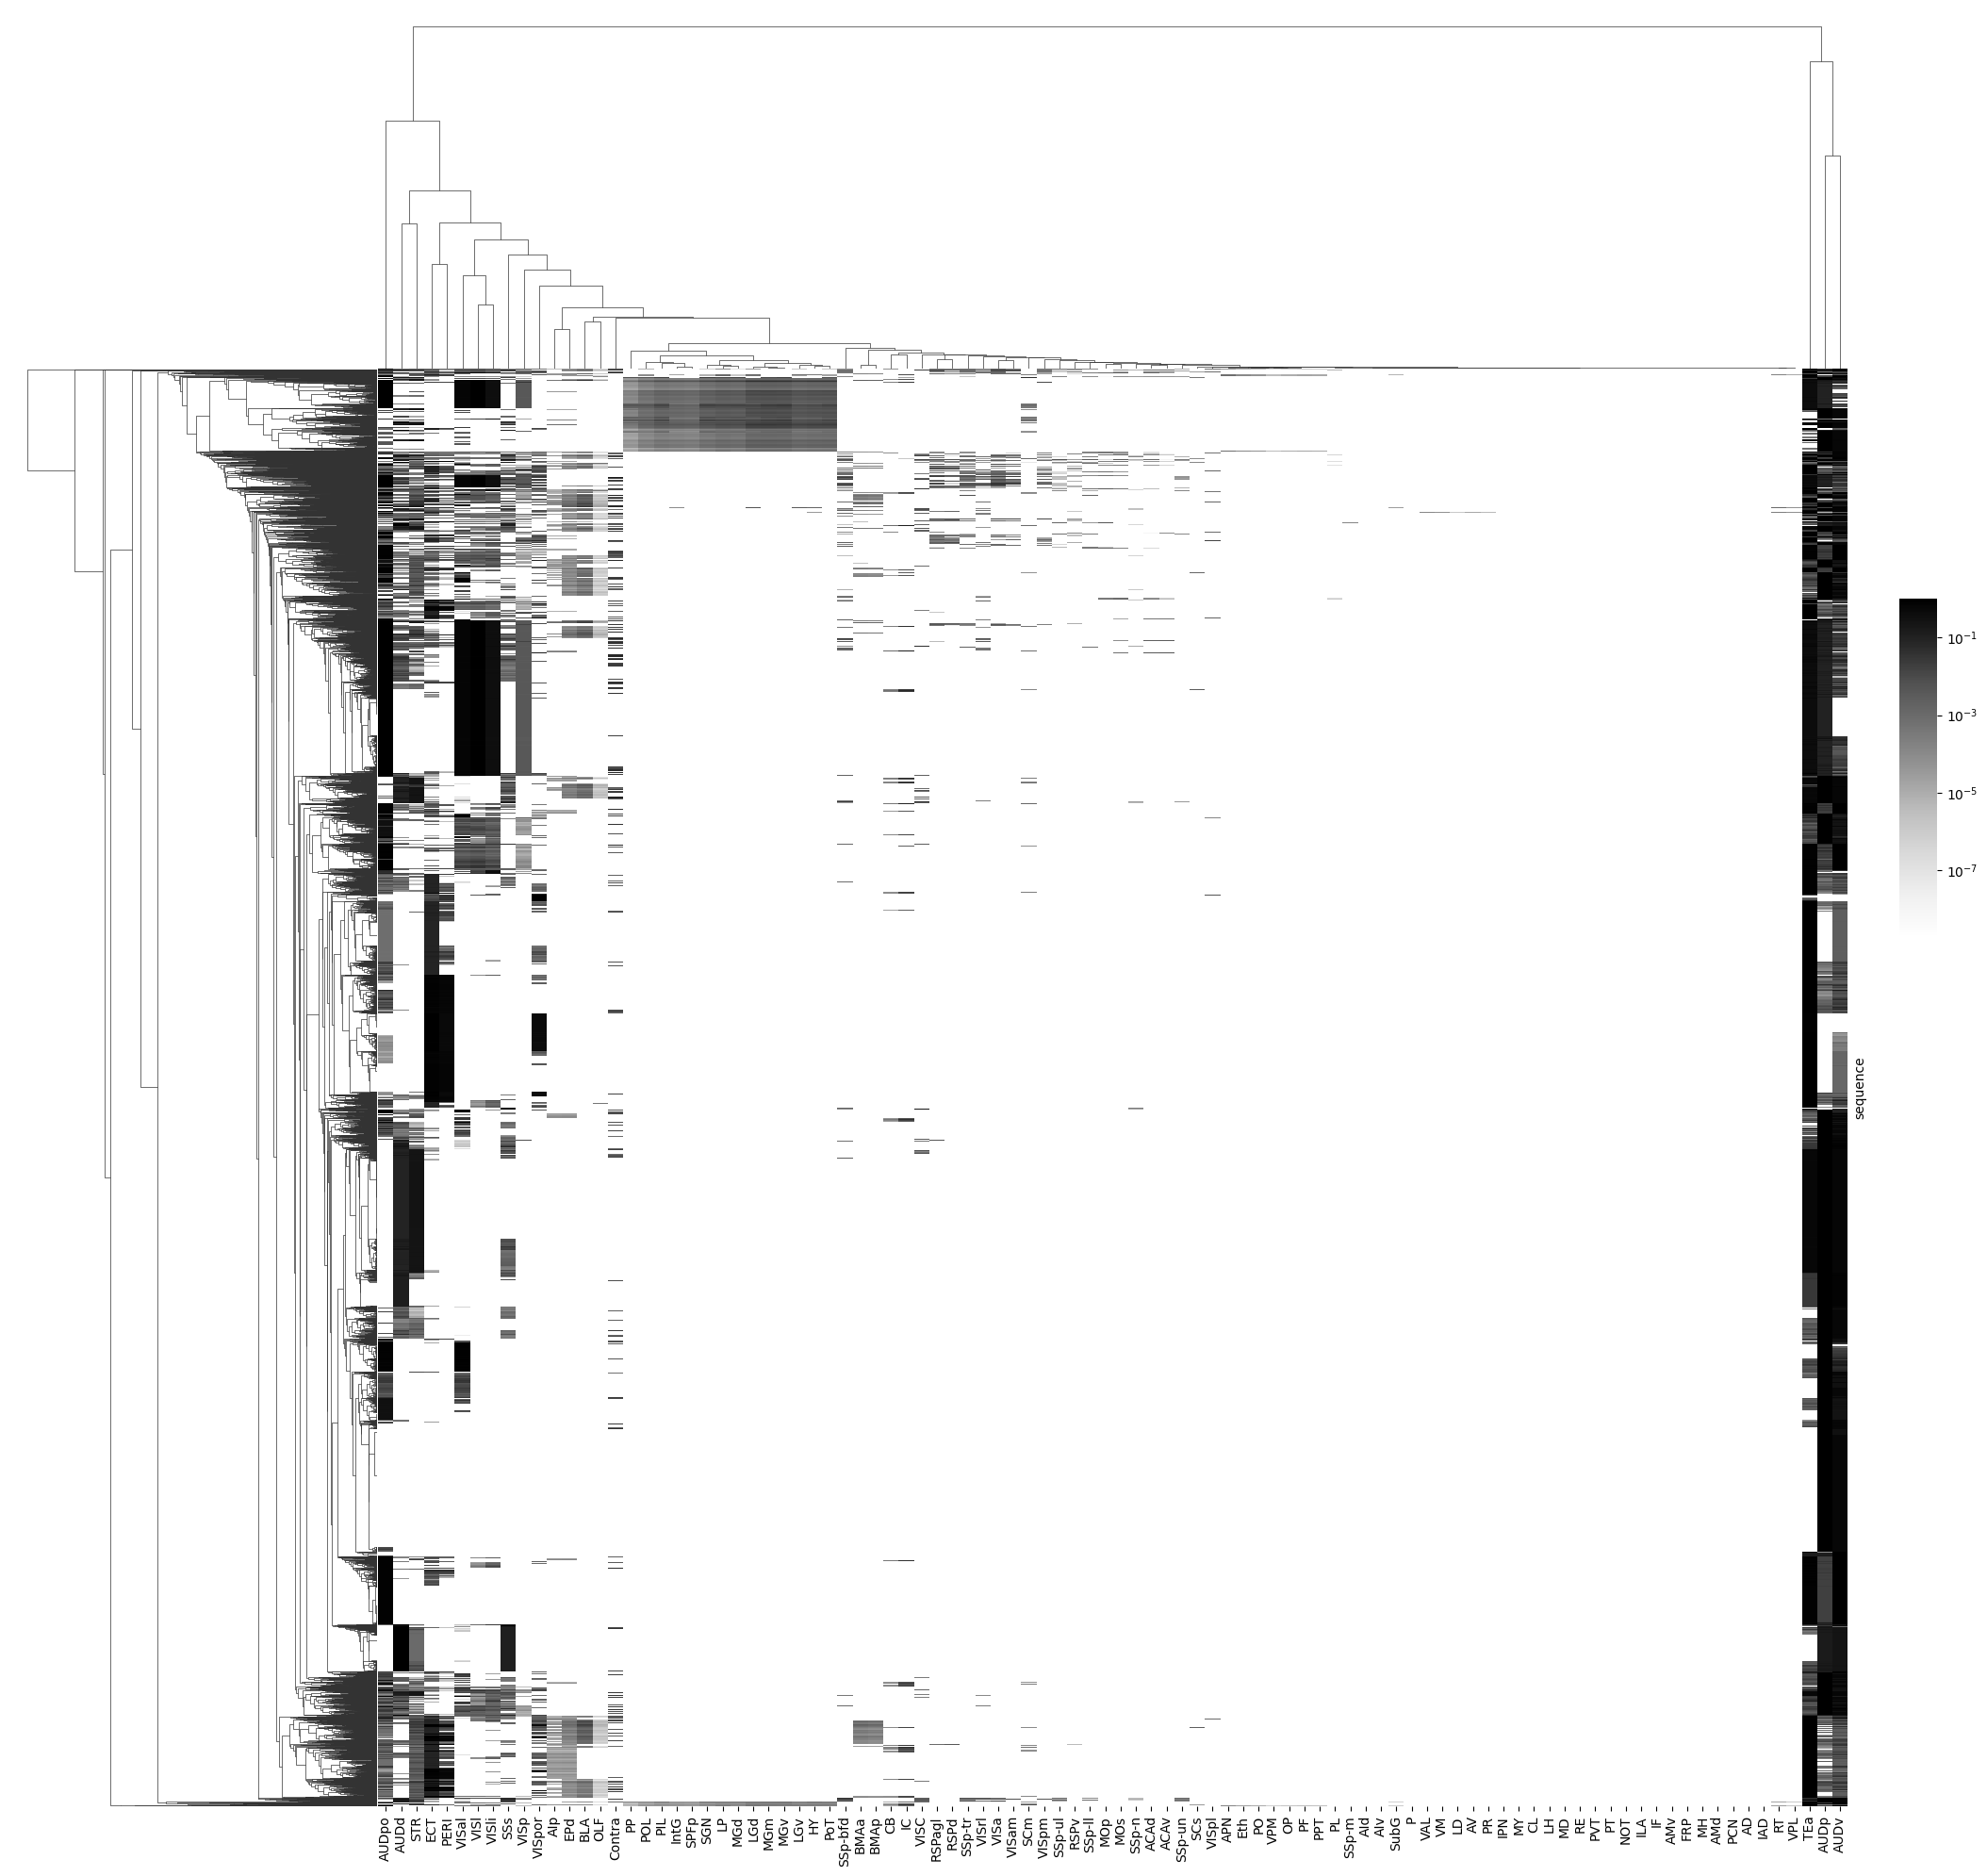

In [15]:
sb.clustermap(bc_matrix, metric='canberra', method='average', standard_scale=0, norm=LogNorm(), cmap="Greys", figsize=(20, 20), yticklabels=False, xticklabels=True, cbar_pos=(1.01, 0.5, 0.02, 0.18))

In [53]:
bc_matrix_A1 = bc_matrix[bc_matrix.idxmax(axis=1) == 'AUDp']
filtered_df = bc_matrix_A1[bc_matrix_A1.filter(like='VIS').gt(0).any(axis=1)]

In [55]:
bc_matrix_A1_FIAA456a = bc_matrix_A1.copy()

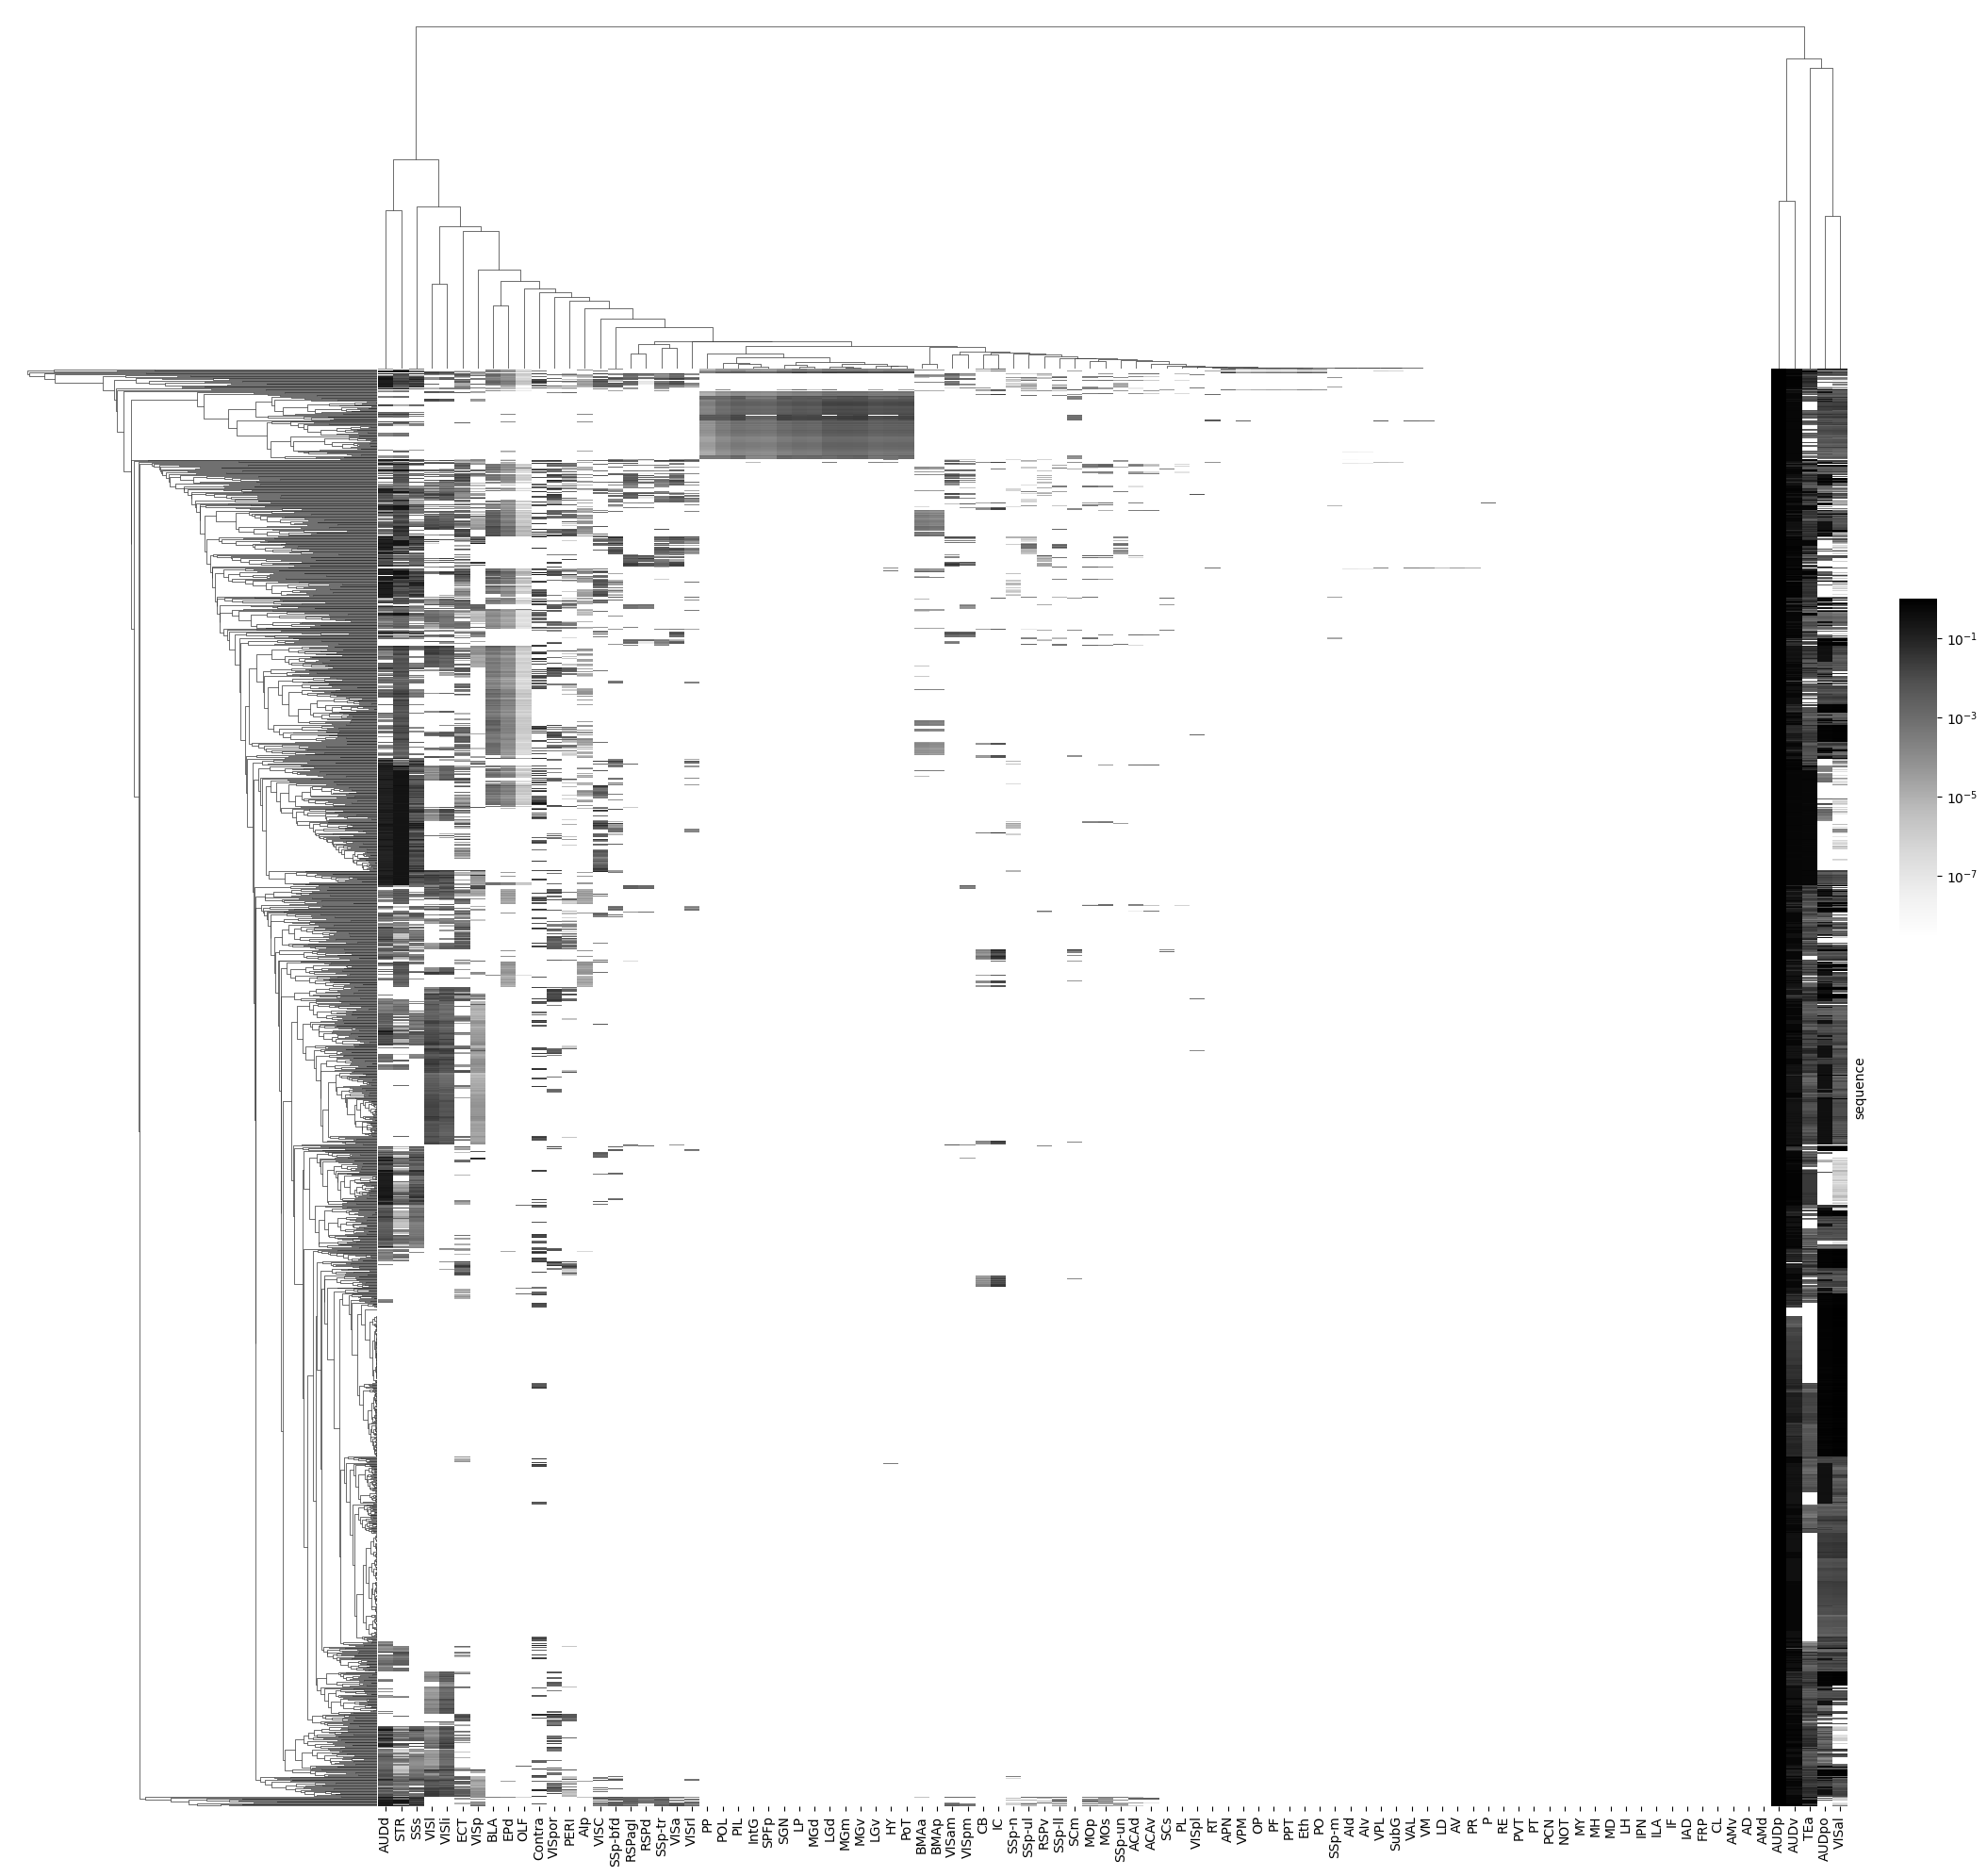

In [54]:
sb.clustermap(filtered_df, metric='canberra', method='average', standard_scale=0, norm=LogNorm(), cmap="Greys", figsize=(20, 20), yticklabels=False, xticklabels=True, cbar_pos=(1.01, 0.5, 0.02, 0.18))

In [18]:
areas_grouped = all_area_FIAA456d.copy()
for group, columns in group_areas.items():
    areas_grouped[group] = areas_grouped.filter(items=columns).sum(axis=1)
    columns = [value for value in columns if value in all_area_FIAA456d.columns]
    areas_grouped = areas_grouped.drop(columns, axis=1)
nontarget_list = ['act', 'ar', 'bic', 'bsc', 'ccb', 'ccb', 'ccg', 'cing', 'cpd', 'csc', 'cst', 'ec', 'fa', 'fi',
    'fiber tracts', 'fp', 'll', 'mcp', 'ml', 'onl', 'or', 'py', 'root', 'sctv', 'scwm', 'tb', 'CTXsp', 'act', 'alv', 'amc', 'cic', 'VL', 'MRN', 'BST', 'CA', 'BLAa', 'BLAp', 'CEAc', 'CEAl', 'CEAm', 'COApm', 'DG-mo',
    'DT', 'GPe', 'GPi', 'HATA', 'HPF', 'IG', 'IGL', 'LSc', 'LSr', 'LT', 'PAL', 'PBG', 'aco', 'ccs', 'chpl', 'dhc', 'ee', 'em', 'int', 'lot', 'lotd', 'moV', 'opt', 'rust', 'sV', 'sm', 'st', 'tspc', 'VS', 'pm', 'DG-sg',
    'NPC', 'SI', 'MEA', 'BLAv', 'BMAa' 'BMAp', 'EPv', 'GPi', 'IA', 'stc']
nontarget_list = [value for value in nontarget_list if value in all_area_FIAA456d.columns]
areas_only_grouped = areas_grouped.drop(nontarget_list, axis=1)

In [19]:
#create a dataframe of the fractions of each brain area contained within each sample
areas_only_grouped = areas_only_grouped.fillna(0)
areas_matrix = areas_only_grouped.to_numpy()
total_frac = np.sum(areas_matrix, axis=1)
frac_matrix = areas_matrix/total_frac[:, np.newaxis]
areasFrac = pd.DataFrame(frac_matrix, columns=areas_only_grouped.columns)

/tmp/ipykernel_207764/566909388.py:5: RuntimeWarning: invalid value encountered in divide
  frac_matrix = areas_matrix/total_frac[:, np.newaxis]


In [29]:
for i in areasFrac.sum(axis=1):
    print(i)

1.0
1.0
0.9999999999999999
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.9999999999999999
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.9999999999999999
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.9999999999999999
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.9999999999999999
1.0
1.0
1.0
1.0
0.9999999999999999
1.0
1.0
1.0
0.9999999999999999
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.9999999999999999
1.0
1.0
1.0
1.0
0.9999999999999999
0.9999999999999999
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.0
1.0
0.9999999999999999
1.0
1.0
1.0
0.9999999999999999
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0000000000000002
1.0
1.0
0.9999999999999999
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.9999999999999999
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


In [20]:
#for each barcode, create a matrix of BC count for regions in a sample based on amount of each region in LCM (makes assumption of equal BC distribution)
#frac_matrix = all_area_fractions_FIAA456a.to_numpy()
bc_matrix = np.zeros(shape=((len(filtered_soma_FIAA456d), (len(areas_only_grouped.columns)))))
bc_matrix = pd.DataFrame(data= bc_matrix, columns=areas_only_grouped.columns, index=filtered_soma_FIAA456d.index)
for i, row in filtered_soma_FIAA456d.iterrows():
    counts = row.to_numpy()
    frac_counts = frac_matrix * counts[:, np.newaxis]
    sample_counts = pd.DataFrame(frac_counts, columns=areas_only_grouped.columns)
    bc_matrix.loc[i] = sample_counts.sum() / frac_matrix.sum()
#remove any columns that are all zeros
#for column in bc_matrix.columns:
 #   if bc_matrix[column].sum() == 0:
  #      bc_matrix.drop([column], axis=1, inplace=True)
bc_matrix = bc_matrix.loc[~(bc_matrix==0).all(axis=1)]
#bc_matrix =bc_matrix.reset_index(drop=True)

FloatingPointError: NaN dissimilarity value.

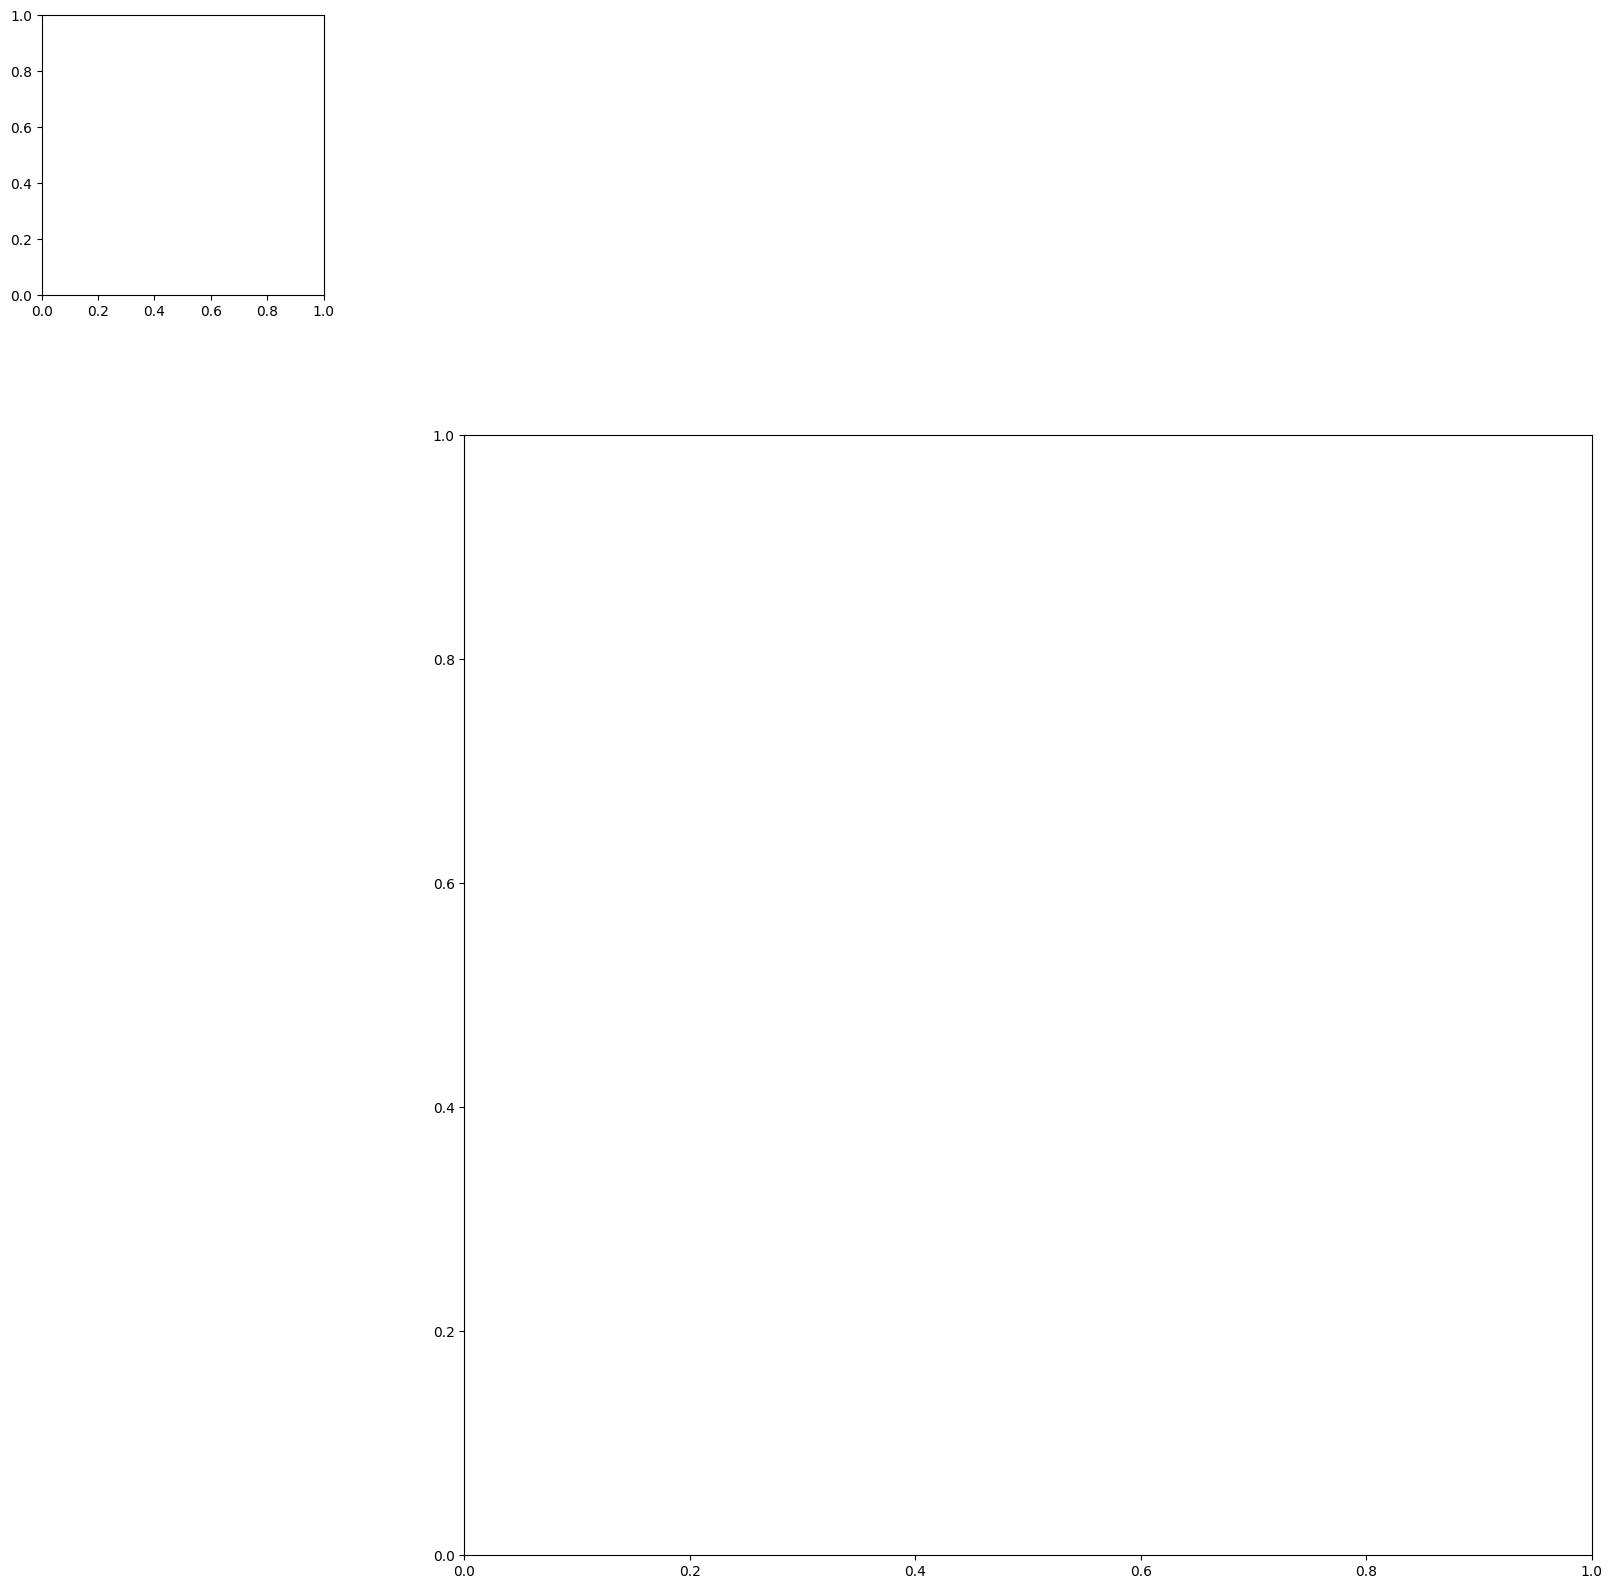

In [21]:
sb.clustermap(bc_matrix, metric='canberra', method='average', standard_scale=0, norm=LogNorm(), cmap="Greys", figsize=(20, 20), yticklabels=False, xticklabels=True, cbar_pos=(1.01, 0.5, 0.02, 0.18))

In [ ]:
bc_matrix_A1 = bc_matrix[bc_matrix.idxmax(axis=1) == 'AUDp']

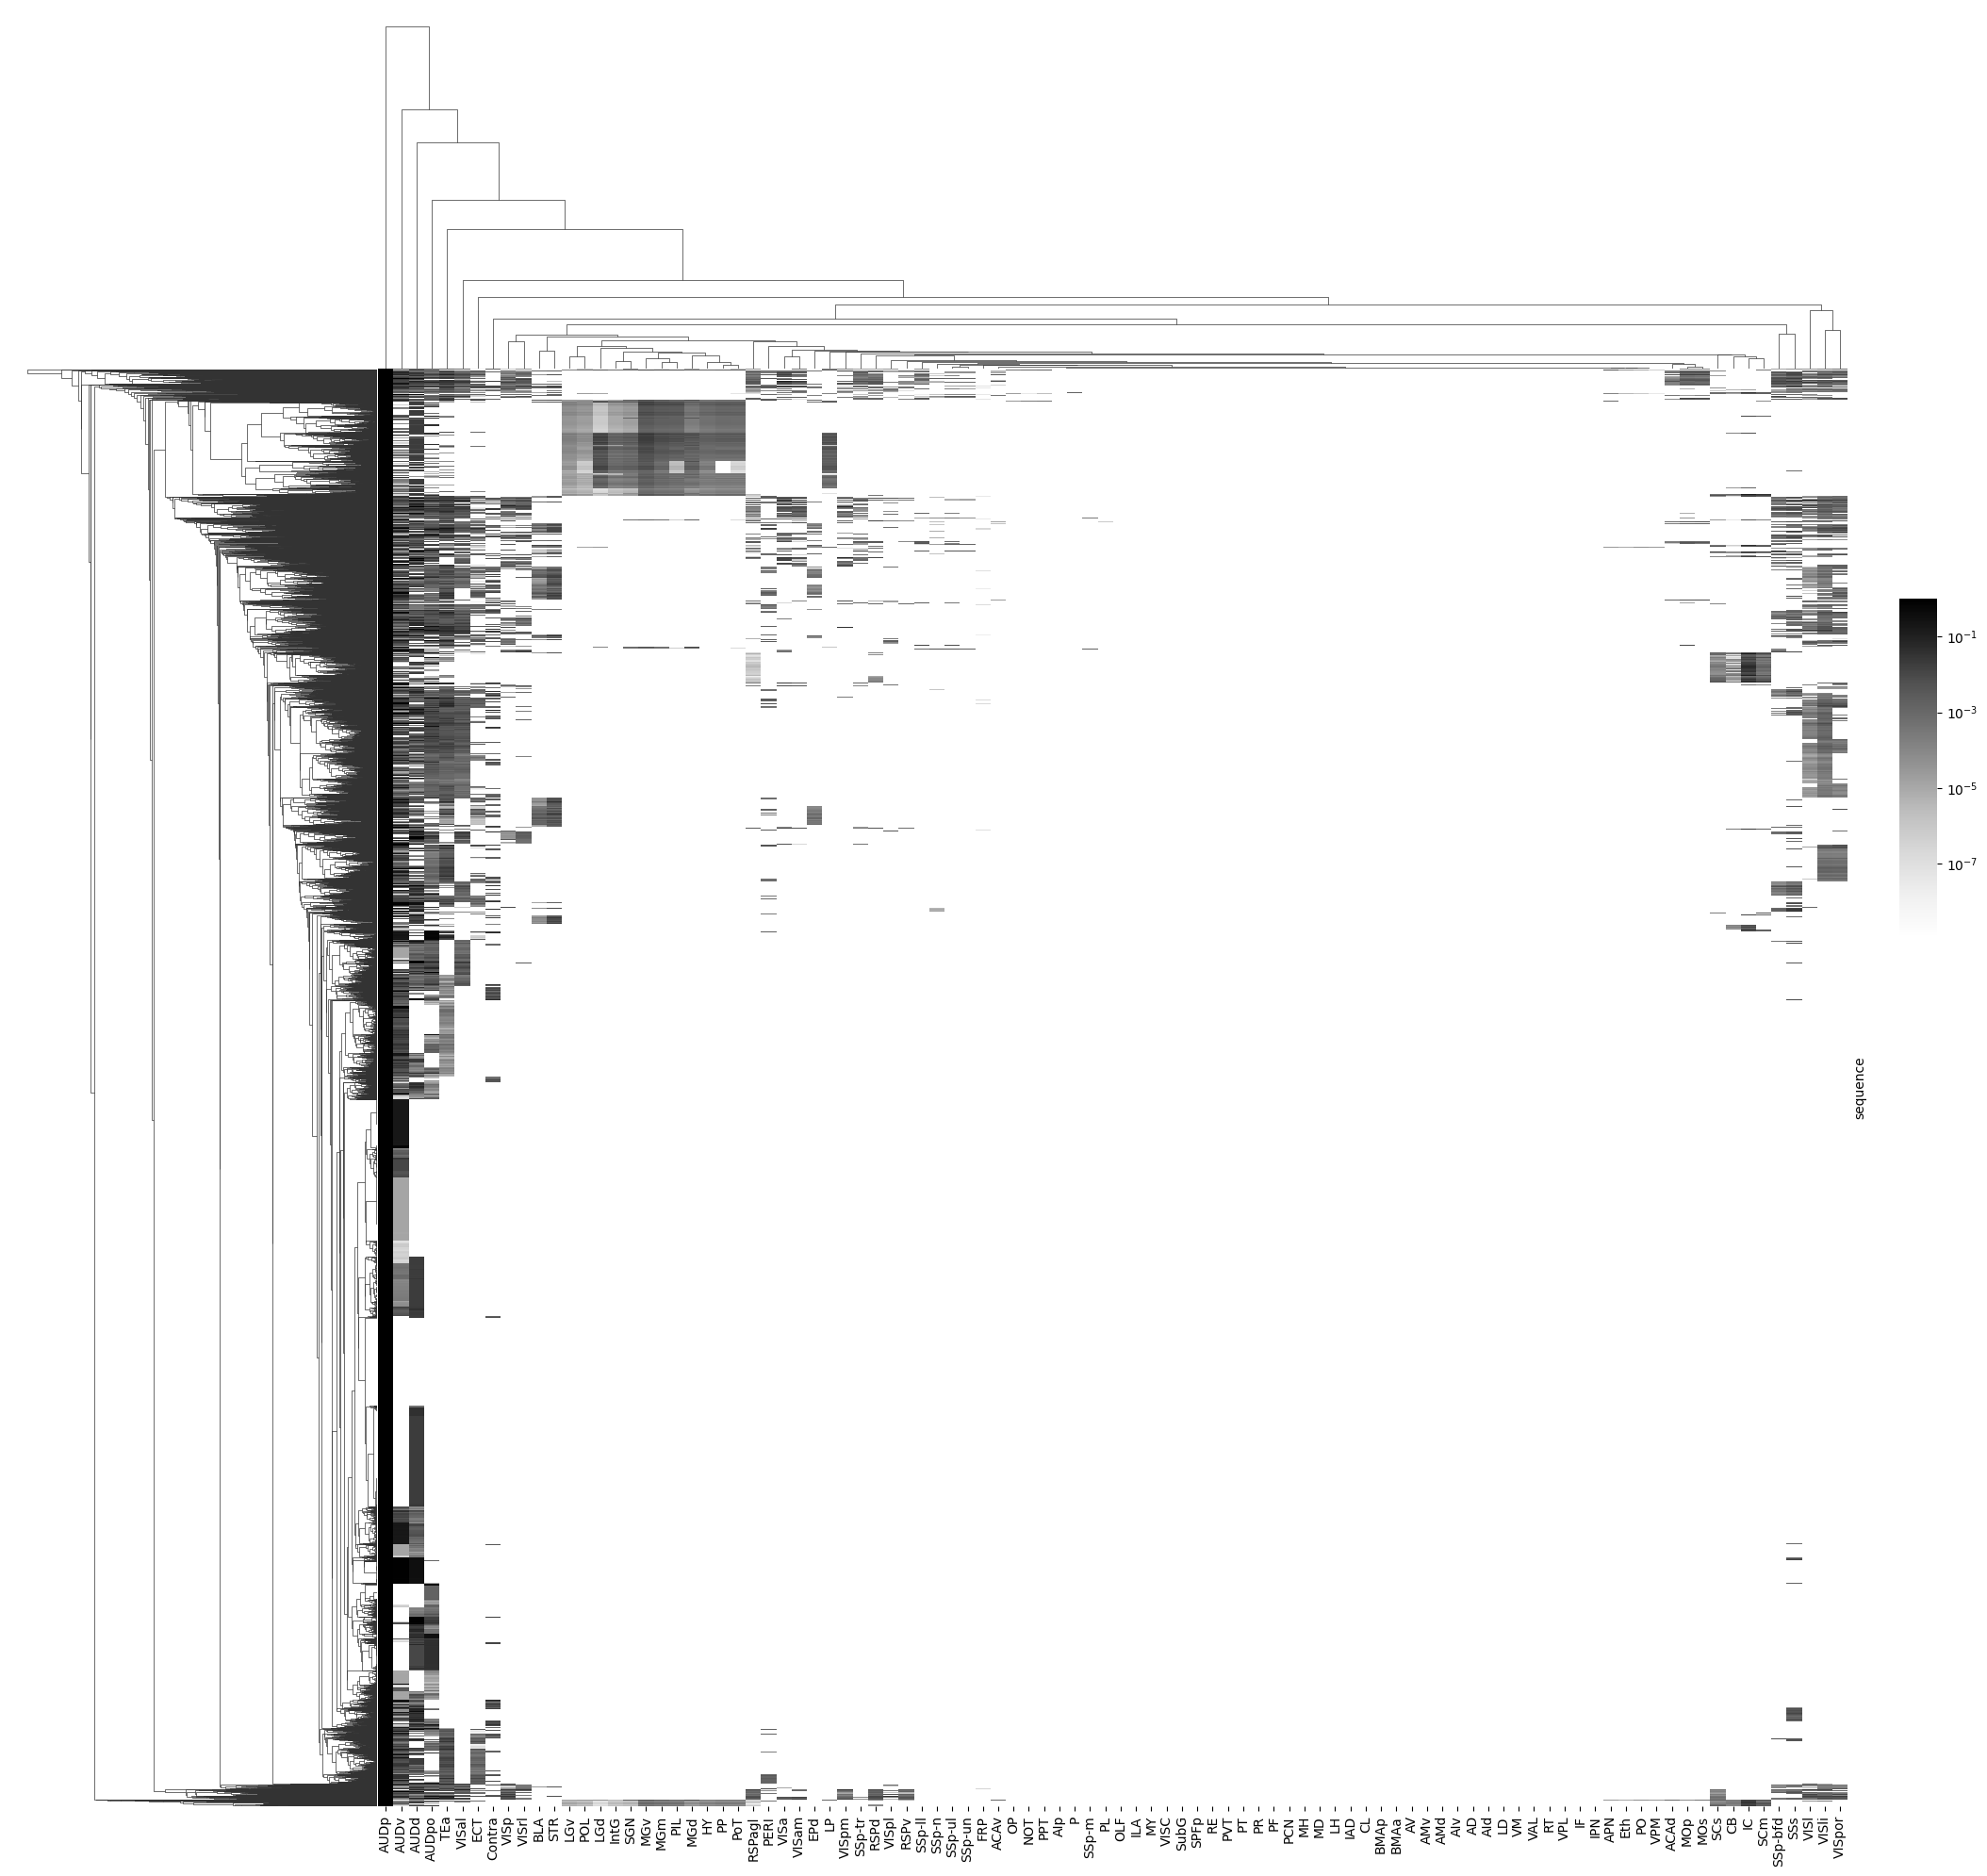

In [ ]:
sb.clustermap(bc_matrix_A1, metric='canberra', method='average', standard_scale=0, norm=LogNorm(), cmap="Greys", figsize=(20, 20), yticklabels=False, xticklabels=True, cbar_pos=(1.01, 0.5, 0.02, 0.18))

In [22]:
bc_matrix_A1 = bc_matrix[bc_matrix.idxmax(axis=1) == 'AUDp']
filtered_df = bc_matrix_A1[bc_matrix_A1.filter(like='VIS').gt(0).any(axis=1)]

In [25]:
bc_matrix

,ACAd,ACAv,AD,AId,AIp,AIv,AMd,AMv,APN,AUDd,...,VISli,VISp,VISpl,VISpm,VISpor,VISrl,VM,VPL,VPM,Contra
sequence,,,,,,,,,,,,,,,,,,,,,
TGAATTTCCCAGGATCGCATCGTCACTATGTT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TAGGTGCGTGATGTTGTGTTCTCCCGGTGATT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GCGTGCGGGGGTTCGTCACCGTTTTCCTGGTC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TAATTGACTAAGTGTGGCTCTGAATGAGTCTT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CGACCCGTGCATGTCTATAGAACGGATGTGTT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CTACACGGGTCTCAGGCGCAGGGACGGTCCTC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CTACAGCGGTGTCATGGGTCGCCTGGAACTCC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CTAATTGGTGGAATACTCTGAATGCACTGCTC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


ValueError: negative dimensions are not allowed

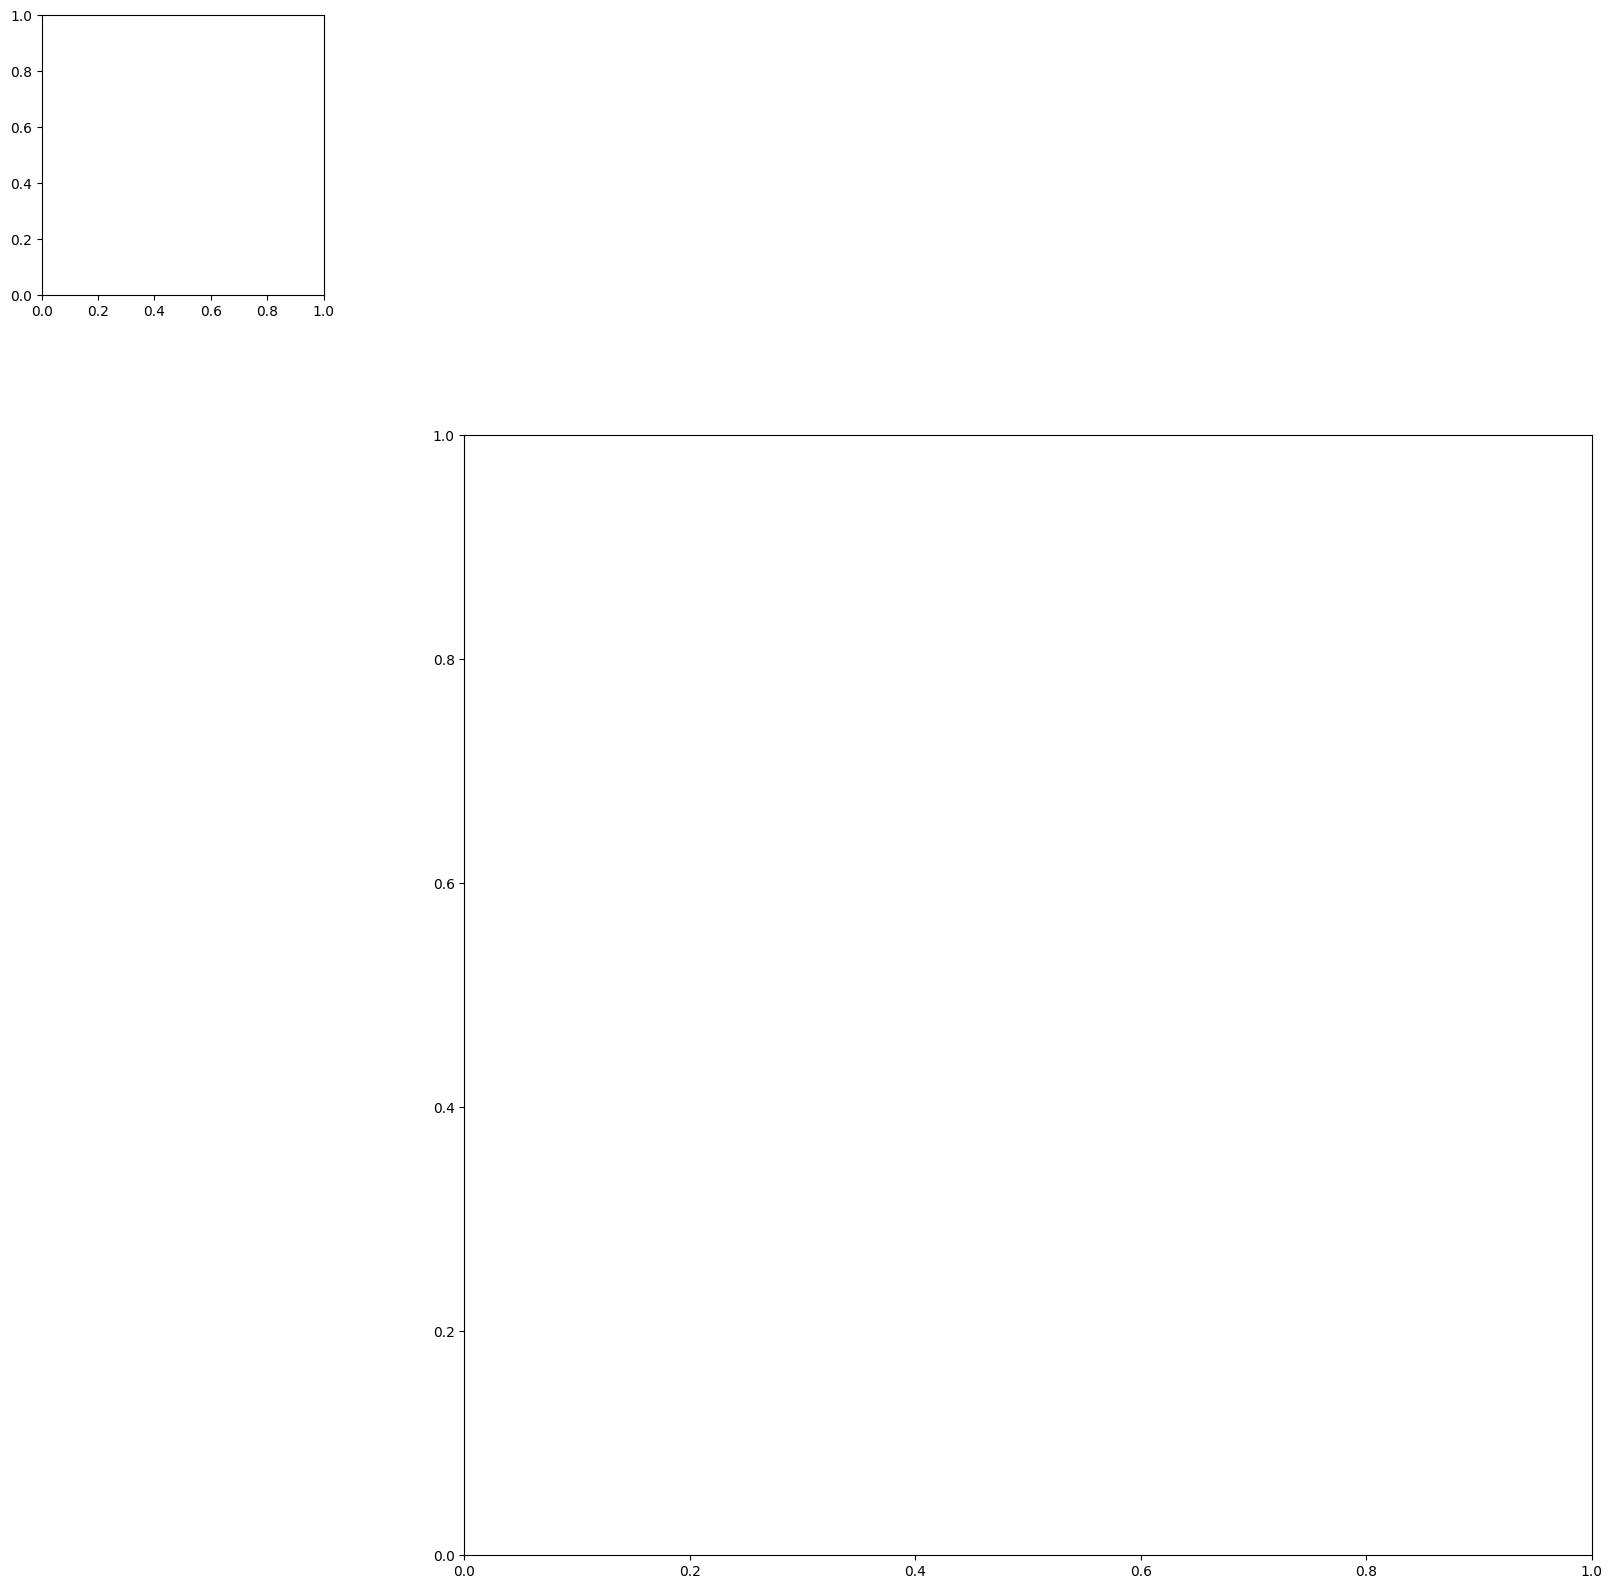

In [23]:
sb.clustermap(filtered_df, metric='canberra', method='average', standard_scale=0, norm=LogNorm(), cmap="Greys", figsize=(20, 20), yticklabels=False, xticklabels=True, cbar_pos=(1.01, 0.5, 0.02, 0.18))

In [62]:
bc_matrix_A1_FIAA456d = bc_matrix_A1.copy()

In [63]:
bc_matrix_A1_FIAA456d

,ACAd,ACAv,AD,AId,AIp,AIv,AMd,AMv,APN,AUDd,...,VISp,VISpl,VISpm,VISpor,VISrl,VM,VPL,VPM,Contra OLF,Contra
sequence,,,,,,,,,,,,,,,,,,,,,
TAGGTGCGTGATGTTGTGTTCTCCCGGTGATT,0.001150,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.204438,...,0.052993,0.001248,0.091328,0.041715,0.005843,0.0,0.0,0.0,0.0,0.019208
GCGTGCGGGGGTTCGTCACCGTTTTCCTGGTC,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.021368,...,0.007640,0.009898,0.000475,0.061967,0.010525,0.0,0.0,0.0,0.0,0.090790
ATCGATCGGGGAGGACCCAGGAGCGTGCGATT,0.002728,0.000035,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.166577,...,0.087647,0.000000,0.006019,0.016092,0.029946,0.0,0.0,0.0,0.0,0.000000
ATTATATGATGGCCGAGGAATCCATATGACTT,0.002932,0.000042,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.004194,...,0.053648,0.000213,0.001984,0.016735,0.000437,0.0,0.0,0.0,0.0,0.000000
GCGGGTTTCGCGGTGGATTTCTGGTATGTTTC,0.005244,0.000111,0.0,0.0,0.000055,0.0,0.0,0.0,0.0,0.178313,...,0.041263,0.000000,0.012806,0.005034,0.020492,0.0,0.0,0.0,0.0,0.007722
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CTAATCCGATCCAAGTTAGGCGCTTGCTCTTT,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.168493,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000
CTACACGTTTTTTCGCACTCGTAATCGTTTCT,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.822875,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000
CTACACGGGTCTCAGGCGCAGGGACGGTCCTC,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000


In [64]:
bc_matrix_A1_FIAA456a

,ACAd,ACAv,AD,AId,AIp,AIv,AMd,AMv,APN,AUDd,...,VISli,VISp,VISpl,VISpm,VISpor,VISrl,VM,VPL,VPM,Contra
sequence,,,,,,,,,,,,,,,,,,,,,
GGAATTTCGTTCGCTCTCGGTAGGTGGCATTT,0.000000,0.000000,0.0,0.0,0.000188,0.0,0.0,0.0,0.0,2.417967,...,0.000000,0.000000,0.000000,0.000000,0.038530,0.00000,0.0,0.0,0.0,0.036854
TGTTGTGCGTTGGTGGGGCATGAAGGGTTCCC,0.000000,0.000000,0.0,0.0,0.000217,0.0,0.0,0.0,0.0,0.000000,...,0.000922,0.000132,0.005393,0.000389,0.023369,0.00234,0.0,0.0,0.0,0.000000
TAATGTATTATCGTTTGGCACAGGTACCAGTT,0.000603,0.000008,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000623,...,0.000235,0.000000,0.000000,0.000000,0.030715,0.00000,0.0,0.0,0.0,0.102358
GTATGCCTGAAAGAACGTGATTGAAACCTTTC,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000623,...,0.005332,0.000000,0.000000,0.000000,0.007516,0.00000,0.0,0.0,0.0,0.015014
GAAGTCTTGAGTTCCATTTTTAGGCTAACGTC,0.000002,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.002372,...,0.004375,0.014723,0.013684,0.006598,0.003643,0.00000,0.0,0.0,0.0,0.064798
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CTCGGAATTACACAGGCATAGATCCGTGGACT,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.000000
CTATGGTGTGGGTCAATTTACTGAAGACTGTT,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.000000
CTATTTTAGCTTAAAAGGACTTATTCAGTGTC,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.000000


In [65]:
concatenated_df = pd.concat([bc_matrix_A1_FIAA456a, bc_matrix_A1_FIAA456d], sort=False)

In [67]:
bc_matrix_combined = concatenated_df.fillna(0)

In [68]:
bc_matrix_combined.to_pickle('/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/weighted_areas_FIAA456d_FIAA456a_combined_A1_source.pkl')

In [ ]:
b